
[STEP 1] RSA Key Generation
Public key: (3, 15), Private key: (3, 15)

[STEP 2] Transmitting encrypted message
Original message: UC IRVINE
Encrypted message: [1, 8, 0, 12, 4, 5, 12, 6, 13]

[STEP 3] Launching quantum attack using Shor's Algorithm...

Attempt 1: Trying a = 2

Quantum Circuit:


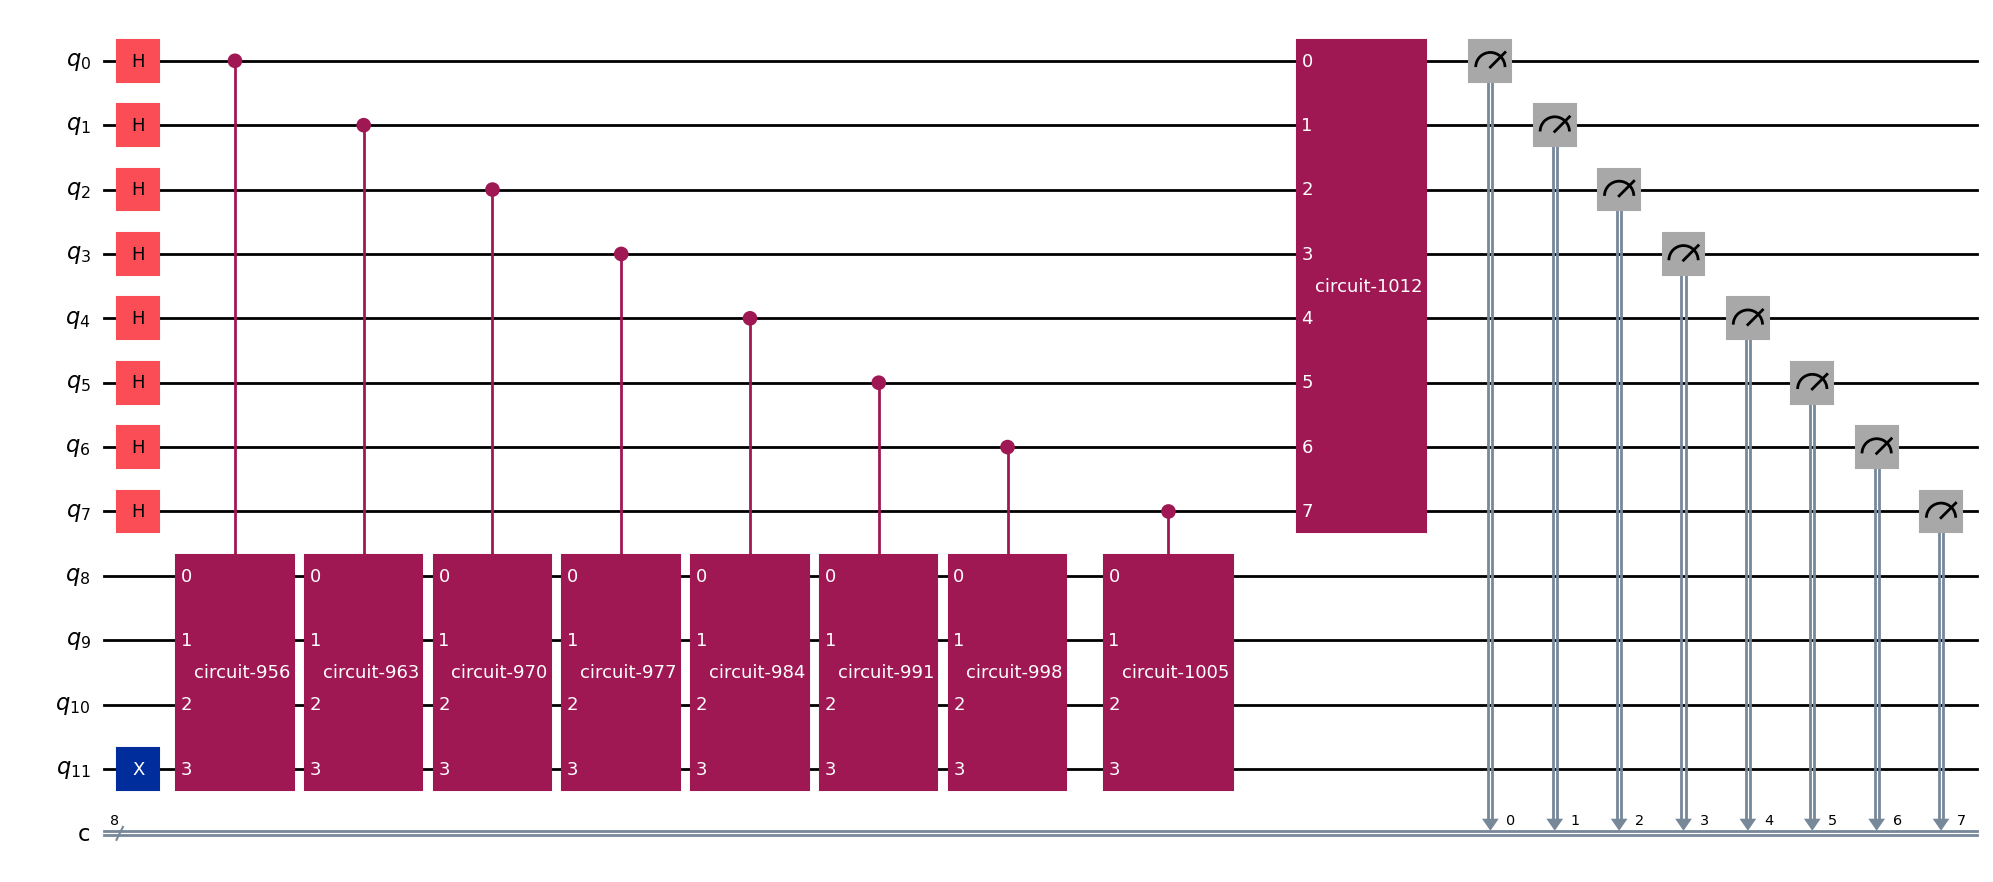


Phase Estimation Results:


,Bitstring,Counts,Phase,Fraction,Candidate r
0,00000000,241,0.0000,0/1,1
1,11000000,252,0.7500,3/4,4
2,01000000,266,0.2500,1/4,4
3,10000000,265,0.5000,1/2,2



Measurement Histogram:
  Trying candidate r = 4
    gcd(a^2 - 1, N) = gcd(3, 15) = 3
    gcd(a^2 + 1, N) = gcd(5, 15) = 5
    Success: Found nontrivial factor 3

[STEP 4] Attack successful!
Recovered prime factors: p = 3, q = 5
Hacked private key: (3, 15)
Decrypted message using hacked key: UC IRVINE
✔ Message match!


In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from fractions import Fraction
from math import gcd
from numpy.random import choice
from random import choices

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, circuit_drawer
from IPython.display import display

# ------------------------
# 1. Define inverse QFT circuit for phase estimation
# ------------------------
def qft_dagger(n):
    qc = QuantumCircuit(n)
    for qubit in range(n // 2):
        qc.swap(qubit, n - qubit - 1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi / float(2 ** (j - m)), m, j)
        qc.h(j)
    return qc

# ------------------------
# 2. Create controlled modular exponentiation for N=15 (hand-coded)
# ------------------------
def c_amod15(a, power):
    a = int(a)
    if a not in [2, 7, 8, 11, 13]:
        raise ValueError("Only a in [2, 7, 8, 11, 13] is supported for N=15.")

    U = QuantumCircuit(4)
    for _ in range(power):
        if a in [2, 13]:
            U.swap(0, 1)
            U.swap(1, 2)
            U.swap(2, 3)
        elif a in [7, 8]:
            U.swap(2, 3)
            U.swap(1, 2)
            U.swap(0, 1)
        elif a == 11:
            U.swap(2, 3)
            U.swap(0, 2)
        if a in [7, 11, 13]:
            for q in range(4):
                U.x(q)
    return U.to_gate().control()

# ------------------------
# 3. Run Quantum Phase Estimation and extract candidate periods
# ------------------------
def run_qpe_trial(a, n_count=8, shots=1024, draw_circuit=False):
    a = int(a)
    qc = QuantumCircuit(n_count + 4, n_count)

    for q in range(n_count):
        qc.h(q)
    qc.x(n_count + 3)

    for q in range(n_count):
        qc.append(c_amod15(a, 2 ** q), [q] + [i + n_count for i in range(4)])

    qc.append(qft_dagger(n_count), range(n_count))
    qc.measure(range(n_count), range(n_count))

    if draw_circuit:
        print("\nQuantum Circuit:")
        fig = circuit_drawer(qc, output='mpl', fold=-1)
        display(fig)

    sim = AerSimulator()
    tqc = transpile(qc, sim)
    result = sim.run(tqc, shots=shots).result()
    counts = result.get_counts()

    rows = []
    for bitstring, count in counts.items():
        decimal = int(bitstring, 2)
        phase = decimal / (2 ** n_count)
        frac = Fraction(phase).limit_denominator(15)
        r = int(frac.denominator)
        rows.append([bitstring, count, f"{phase:.4f}", f"{frac.numerator}/{frac.denominator}", r])

    df = pd.DataFrame(rows, columns=["Bitstring", "Counts", "Phase", "Fraction", "Candidate r"])
    return df, counts, qc

# ------------------------
# 4. Attempt to factor N using guessed period r
# ------------------------
def try_factorization(a, N, r):
    a, N, r = int(a), int(N), int(r)
    print(f"  Trying candidate r = {r}")

    if r % 2 != 0:
        print(f"    Rejected: r is not even")
        return None

    if pow(a, r, N) != 1:
        print(f"    Rejected: a^{r} mod N ≠ 1")
        return None

    x1 = pow(a, r // 2) - 1
    x2 = pow(a, r // 2) + 1
    guess1 = gcd(x1, N)
    guess2 = gcd(x2, N)

    print(f"    gcd(a^{r//2} - 1, N) = gcd({x1}, {N}) = {guess1}")
    print(f"    gcd(a^{r//2} + 1, N) = gcd({x2}, {N}) = {guess2}")

    if 1 < guess1 < N:
        print(f"    Success: Found nontrivial factor {guess1}")
        return guess1
    if 1 < guess2 < N:
        print(f"    Success: Found nontrivial factor {guess2}")
        return guess2

    print("    Failed to find nontrivial factor.")
    return None

# ------------------------
# 5. RSA encryption/decryption using restricted character table
# ------------------------
char_table = ' UCIRVNEHADLM'
char_to_num = {ch: i for i, ch in enumerate(char_table)}
num_to_char = {i: ch for i, ch in enumerate(char_table)}

def rsa_encrypt_custom(message, pubkey):
    encoded = []
    for ch in message:
        if ch in char_to_num:
            num = char_to_num[ch]
            encoded.append(rsa_encrypt(num, pubkey))
    return encoded

def rsa_decrypt_custom(cipher_list, privkey):
    try:
        return ''.join(num_to_char[rsa_decrypt(c, privkey)] for c in cipher_list)
    except:
        return "(Decoding failed)"

def rsa_encrypt(m, pubkey):
    e, N = pubkey
    return pow(m, e, N)

def rsa_decrypt(c, privkey):
    d, N = privkey
    return pow(c, d, N)

# ------------------------
# 6. Main simulation: RSA message transmission and Shor attack
# ------------------------
N = 15
n_count = 8
shots = 1024
e = 3

# Select random valid plaintext message
valid_messages = [
    "UC IRVINE",
    "HAD A VAN",
    "NICE RIDE",
    "LIVE IN LA",
    "LUNCH MADE"
]
valid_messages = [m for m in valid_messages if all(c in char_table for c in m)]
message_str = choice(valid_messages)

# STEP 1: RSA key generation
print("\n[STEP 1] RSA Key Generation")
p = 3
q = 5
phi = (p - 1) * (q - 1)
d = pow(e, -1, phi)
pubkey = (e, N)
privkey = (d, N)
print(f"Public key: {pubkey}, Private key: {privkey}")

# STEP 2: Message encryption and transmission
print("\n[STEP 2] Transmitting encrypted message")
print(f"Original message: {message_str}")
cipher_list = rsa_encrypt_custom(message_str, pubkey)
print(f"Encrypted message: {cipher_list}")

# STEP 3: Simulate Shor's algorithm to hack the private key
print("\n[STEP 3] Launching quantum attack using Shor's Algorithm...")
attempt = 0
success = False
for a in [2, 7, 8, 11, 13]:
    attempt += 1
    print(f"\nAttempt {attempt}: Trying a = {a}")
    df, counts, qc = run_qpe_trial(a, shots=shots, draw_circuit=(attempt == 1))

    print("\nPhase Estimation Results:")
    display(df)
    print("\nMeasurement Histogram:")
    plot_histogram(counts, title=f"QPE Measurement Histogram (a = {a})")
    plt.show()

    df_sorted = df.sort_values(by="Counts", ascending=False)
    for _, row in df_sorted.iterrows():
        r = int(row["Candidate r"])
        factor = try_factorization(a, N, r)
        if factor:
            other = N // factor
            phi_hacked = (factor - 1) * (other - 1)
            d_hacked = pow(e, -1, phi_hacked)
            privkey_hacked = (d_hacked, N)
            success = True
            break
    if success:
        break

# STEP 4: Compare hacked key and decrypt message
if success:
    print("\n[STEP 4] Attack successful!")
    print(f"Recovered prime factors: p = {factor}, q = {other}")
    print(f"Hacked private key: {privkey_hacked}")
    decrypted_message = rsa_decrypt_custom(cipher_list, privkey_hacked)
    print(f"Decrypted message using hacked key: {decrypted_message}")
    print("✔ Message match!" if decrypted_message == message_str else "✘ Message mismatch.")
else:
    print("\n[STEP 4] Attack failed: Could not factor N")